# Calibration Tutorial - Fort Peck, MT - Unirrigated Flux Plot

## Step 1: Uncalibrated Model Run

This tutorial focuses on calibrating SWIM-RS for a single unirrigated plot: a 3-pixel buffer around FluxNet's US-FPe eddy covariance station from John Volk's Flux ET benchmark dataset. The flux station provides independent observations of both meteorology and ET flux, allowing us to validate our model.

This notebook demonstrates:
1. Loading pre-built model input data
2. Running the uncalibrated SWIM model
3. Comparing model output with flux tower observations

**Reference:** This example is based on John Volk's flux footprint study:
- Paper: https://www.sciencedirect.com/science/article/pii/S0168192323000011
- Data: https://www.sciencedirect.com/science/article/pii/S2352340923003931

---

### Data Pipeline

**Input Data:** The `data/prepped_input.json` file contains pre-computed input data.

The input data workflow uses the **SwimContainer** for data management, and can be re-run if needed:

1. **Extract data** from Earth Engine and GridMET:
   ```bash
   cd data/
   python extract_data.py           # Extract US-FPe only (default)
   python extract_data.py --help    # See all options
   ```

2. **Sync from bucket** after EE tasks complete:
   ```bash
   gsutil -m rsync -r gs://wudr/2_Fort_Peck/ ./data/
   ```

3. **Build model inputs** using the container:
   ```bash
   cd data/
   python build_inputs.py           # Build container and export prepped_input.json
   python build_inputs.py --rebuild # Force rebuild from scratch
   ```

The container (`data/2_Fort_Peck.swim/`) stores all ingested data with provenance tracking.
The model reads from `data/prepped_input.json` which is exported from the container.

---

In [1]:
import os
import sys
import time
import zipfile

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

root = os.path.abspath('../..')
sys.path.append(root)

from swimrs.swim.config import ProjectConfig
from swimrs.swim.sampleplots import SamplePlots
from swimrs.model.obs_field_cycle import field_day_loop

from swimrs.viz.swim_timeseries import plot_swim_timeseries

%matplotlib inline

## 1. Project Setup

Define paths and unzip pre-built data if needed.

In [2]:
project_ws = os.path.abspath('.')
data = os.path.join(project_ws, 'data')

config_file = os.path.join(project_ws, '2_Fort_Peck.toml')
prepped_input = os.path.join(data, 'prepped_input.json')

# Unzip data files if they haven't been extracted
prepped_zip = os.path.join(data, 'prepped_input.zip')
flux_zip = os.path.join(data, 'US-FPe_daily_data.zip')

if os.path.exists(prepped_zip) and not os.path.exists(prepped_input):
    print("Extracting prepped_input.zip...")
    with zipfile.ZipFile(prepped_zip, 'r') as z:
        z.extractall(data)

flux_csv = os.path.join(data, 'US-FPe_daily_data.csv')
if os.path.exists(flux_zip) and not os.path.exists(flux_csv):
    print("Extracting US-FPe_daily_data.zip...")
    with zipfile.ZipFile(flux_zip, 'r') as z:
        z.extractall(data)

print(f"Project workspace: {project_ws}")
print(f"Config file: {config_file}")
print(f"Input data: {prepped_input}")

Project workspace: /home/dgketchum/code/swim-rs/examples/2_Fort_Peck
Config file: /home/dgketchum/code/swim-rs/examples/2_Fort_Peck/2_Fort_Peck.toml
Input data: /home/dgketchum/code/swim-rs/examples/2_Fort_Peck/data/prepped_input.json


In [3]:
# Load the project configuration
config = ProjectConfig()
config.read_config(config_file, project_ws)

### Optional: Query Data from Container

The SwimContainer provides direct access to ingested data for exploration and analysis.
This is useful for inspecting data without running the full model.

In [4]:
# Example: Query data directly from the SwimContainer
from swimrs.container import SwimContainer

container_path = os.path.join(data, '2_Fort_Peck.swim')

if os.path.exists(container_path):
    container = SwimContainer.open(container_path, mode='r')
    
    # List available fields
    print(f"Fields in container: {container.field_uids}")
    
    # Get all time series for a single field using field_timeseries
    ts_df = container.query.field_timeseries('US-FPe')
    print(f"\nTime series shape: {ts_df.shape}")
    print(f"Variables: {list(ts_df.columns)[:10]}...")
    
    # Query specific data using dataframe with zarr paths
    # Path structure: remote_sensing/{type}/{instrument}/{model}/{mask}
    ndvi_df = container.query.dataframe("remote_sensing/ndvi/landsat/inv_irr", fields=['US-FPe'])
    print(f"\nNDVI observations: {ndvi_df.notna().sum().values[0]}")
    
    etf_df = container.query.dataframe("remote_sensing/etf/landsat/ssebop/inv_irr", fields=['US-FPe'])
    print(f"ETf observations: {etf_df.notna().sum().values[0]}")
    
    # Show container status
    print("\n" + container.query.status())
    
    container.close()
else:
    print(f"Container not found at {container_path}")
    print("Run: cd data && python build_inputs.py --rebuild")

Fields in container: ['US-FPe']

Time series shape: (13149, 18)
Variables: ['meteorology_gridmet_etr_corr', 'meteorology_gridmet_ea', 'meteorology_gridmet_tmax', 'meteorology_gridmet_u2', 'meteorology_gridmet_eto', 'meteorology_gridmet_eto_corr', 'meteorology_gridmet_prcp', 'meteorology_gridmet_srad', 'meteorology_gridmet_tmin', 'meteorology_gridmet_etr']...

NDVI observations: 804
ETf observations: 788

CONTAINER STATUS
  URI: file:///home/dgketchum/code/swim-rs/examples/2_Fort_Peck/data/2_Fort_Peck.swim
  Storage: directory
  Fields: 1
  Date range: 1987-01-01 to 2022-12-31
  Days: 13149

DATA PATHS:
----------------------------------------

  derived/
    dynamics/gwsub_data: shape=(1,), 100.0% non-empty
    dynamics/irr_data: shape=(1,), 100.0% non-empty
    dynamics/kc_max: shape=(1,), 100.0% valid
    dynamics/ke_max: shape=(1,), 100.0% valid
    merged_ndvi/inv_irr: shape=(13149, 1), 6.1% valid
    merged_ndvi/irr: shape=(13149, 1), 0.0% valid

  geometry/
    area_m2: shape=(1,

## 2. About the Study Site

The US-FPe flux site is located at Fort Peck, Montana. We use a simple 150-meter buffer around the flux tower instead of the sophisticated flux footprint polygons from the Volk et al. study.

According to IrrMapper data, this location has never been irrigated, making it ideal for testing non-irrigated model parameterization.

Site: US-FPe
Number of fields: 1


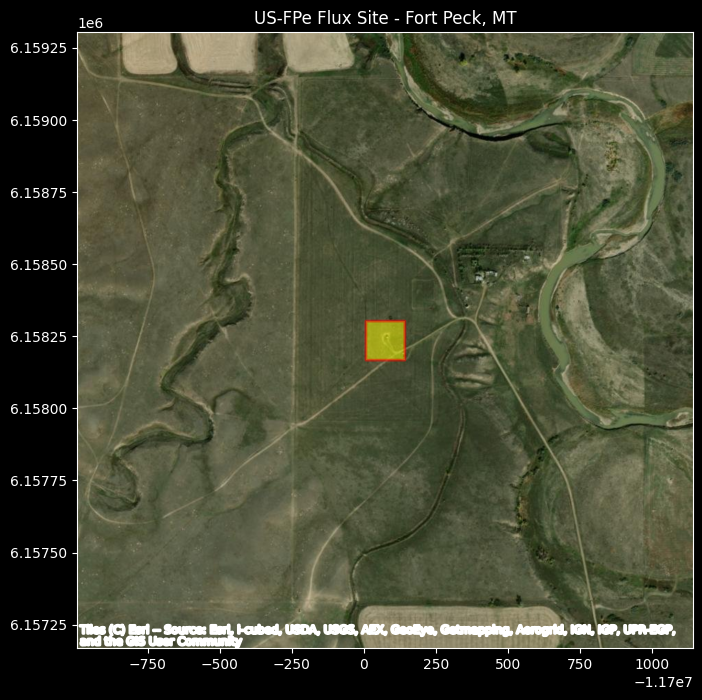

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt

import contextily as ctx

gdf = gpd.read_file(config.fields_shapefile)
selected_feature = 'US-FPe'

print(f"Site: {selected_feature}")
print(f"Number of fields: {len(gdf)}")

# Plot the study area
fig, ax = plt.subplots(figsize=(8, 8))
gdf_plot = gdf.to_crs(epsg=3857)
gdf_plot.plot(ax=ax, edgecolor='red', facecolor='yellow', alpha=0.5, linewidth=2)

# Zoom out by expanding bounds (5km buffer around site)
bounds = gdf_plot.total_bounds
buffer = 1000  # buffer in meters
ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

ax.set_title(f'US-FPe Flux Site - Fort Peck, MT')
plt.show()

## 3. Run the Uncalibrated Model

We define a helper function to run the SWIM model and capture its output.

In [ ]:
def run_fields(ini_path, project_ws, selected_feature, output_csv, forecast=False):
    """Run SWIM model and save combined input/output to CSV."""
    start_time = time.time()

    config = ProjectConfig()
    config.read_config(ini_path, project_ws, forecast=forecast)

    fields = SamplePlots()
    fields.initialize_plot_data(config)
    fields.output = field_day_loop(config, fields, debug_flag=True)

    end_time = time.time()
    print(f'\nExecution time: {end_time - start_time:.2f} seconds\n')

    out_df = fields.output[selected_feature].copy()
    in_df = fields.input_to_dataframe(selected_feature)
    
    # Drop columns from input that already exist in output to avoid duplicates
    overlap_cols = out_df.columns.intersection(in_df.columns)
    if len(overlap_cols) > 0:
        in_df = in_df.drop(columns=overlap_cols)
    
    df = pd.concat([out_df, in_df], axis=1, ignore_index=False)
    df.to_csv(output_csv)
    
    return df

In [7]:
selected_feature = 'US-FPe'
out_csv = os.path.join(project_ws, f'combined_output_{selected_feature}_uncalibrated.csv')

df = run_fields(config_file, project_ws, selected_feature=selected_feature, output_csv=out_csv)

USING PARAMETER DEFAULTS

Execution time: 10.20 seconds



In [16]:
print(f"Output shape: {df.shape}")
print(f"\nKey output columns:")
key_cols = ['et_act', 'etref', 'kc_act', 'kc_bas', 'ks', 'ke', 'melt', 'rain', 
            'depl_root', 'swe', 'ppt', 'irrigation', 'soil_water']
for col in key_cols:
    if col in df.columns:

        print(f"  {col}: mean={df[col].mean():.3f}, max={df[col].max():.3f}")

Output shape: (13149, 75)

Key output columns:
  et_act: mean=0.929, max=4.965
  etref: mean=3.001, max=12.700
  kc_act: mean=0.315, max=0.691
  kc_bas: mean=0.339, max=0.698
  ks: mean=0.582, max=1.000
  ke: mean=0.239, max=0.326
  melt: mean=0.115, max=19.846
  rain: mean=0.823, max=62.700
  depl_root: mean=473.328, max=564.238


TypeError: unsupported format string passed to Series.__format__

## 4. Visualize Model Output

Let's examine a single year (2004) to see the model's behavior.

In [ ]:
ydf = df.loc['2004-01-01': '2004-12-31']
print(f'Total irrigation: {ydf.irrigation.sum():.1f} mm')
print(f'Total ET: {ydf.et_act.sum():.1f} mm')
print(f'Total precipitation: {ydf.ppt.sum():.1f} mm')

plot_swim_timeseries(ydf, ['et_act', 'etref', 'rain', 'melt', 'irrigation'], 
                     start='2004-01-01', end='2004-12-31', png_dir='et_uncalibrated.png')

## 5. Compare with Flux Tower Observations

Now we have three estimates of ET as a ratio of reference ET (ETf or Kc):

1. **SSEBop ETf**: Remote sensing retrievals on Landsat overpass dates
2. **SWIM Kc_act**: Model-estimated actual crop coefficient (analogous to ETf)
3. **Flux EToF**: Independent observations from the eddy covariance tower (Volk et al.)

Let's compare the agreement between these estimates:

In [ ]:
def compare_etf_estimates(combined_output_path, flux_data_path, irr=False):
    """Compare model Kc_act and SSEBop ETf against flux tower observations."""
    flux_data = pd.read_csv(flux_data_path, index_col='date', parse_dates=True)['EToF']

    output = pd.read_csv(combined_output_path, index_col=0)
    output.index = pd.to_datetime(output.index)

    if irr:
        etf = 'etf_irr'
        ct = 'etf_irr_ct' if 'etf_irr_ct' in output.columns else None
    else:
        etf = 'etf_inv_irr'
        ct = 'etf_inv_irr_ct' if 'etf_inv_irr_ct' in output.columns else None

    comparison_df = pd.DataFrame({'kc_act': output['kc_act'],
                                  'etf': output[etf],
                                  'EToF': flux_data})

    # Filter for days that have a SSEBop ETf retrieval and a flux observation
    comparison_df = comparison_df.dropna()

    # If count column exists, filter for single retrievals only
    if ct:
        comparison_df['ct'] = output.loc[comparison_df.index, ct]
        comparison_df = comparison_df.loc[comparison_df['ct'] == 1]
        comparison_df = comparison_df.drop(columns=['ct'])

    if len(comparison_df) == 0:
        print("No overlapping data between model ETf and flux tower observations")
        return comparison_df

    # Calculate RMSE and R-squared
    rmse_kc_act = np.sqrt(mean_squared_error(comparison_df['EToF'], comparison_df['kc_act']))
    r2_kc_act = r2_score(comparison_df['EToF'], comparison_df['kc_act'])

    rmse_ssebop = np.sqrt(mean_squared_error(comparison_df['EToF'], comparison_df['etf']))
    r2_ssebop = r2_score(comparison_df['EToF'], comparison_df['etf'])

    print(f"Comparison with {len(comparison_df)} overlapping observations:")
    print(f"SWIM Kc_act vs. Flux EToF: RMSE = {rmse_kc_act:.2f}, R-squared = {r2_kc_act:.2f}")
    print(f"SSEBop ETf vs. Flux EToF: RMSE = {rmse_ssebop:.2f}, R-squared = {r2_ssebop:.2f}")

    return comparison_df

In [ ]:
flux_data = os.path.join(data, 'US-FPe_daily_data.csv')
comparison_df = compare_etf_estimates(out_csv, flux_data, irr=False)

## Summary

The uncalibrated model performs comparably to SSEBop using default parameters. Neither achieves particularly good agreement with the flux observations, as indicated by the negative R-squared values.

**Next step:** In notebook `02_calibration.ipynb`, we'll use PEST++ to calibrate the model parameters and see if we can significantly improve performance.

**Key insight:** We're not using the flux data for calibration - it's only for validation. For calibration, we rely solely on widely-available remote sensing data (SSEBop ETf and SNODAS SWE).

In [ ]:
# Create a scatter plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
ax1.scatter(comparison_df['EToF'], comparison_df['kc_act'], alpha=0.5, s=10)
ax1.plot([0, 1.5], [0, 1.5], 'r--', label='1:1 line')
ax1.set_xlabel('Flux EToF')
ax1.set_ylabel('SWIM Kc_act')
ax1.set_title('SWIM vs Flux (Uncalibrated)')
ax1.legend()
ax1.set_xlim(0, 1.5)
ax1.set_ylim(0, 1.5)

ax2 = axes[1]
ax2.scatter(comparison_df['EToF'], comparison_df['etf'], alpha=0.5, s=10)
ax2.plot([0, 1.5], [0, 1.5], 'r--', label='1:1 line')
ax2.set_xlabel('Flux EToF')
ax2.set_ylabel('SSEBop ETf')
ax2.set_title('SSEBop vs Flux')
ax2.legend()
ax2.set_xlim(0, 1.5)
ax2.set_ylim(0, 1.5)

plt.tight_layout()
plt.savefig('comparison_scatter_uncalibrated.png', dpi=150)
plt.show()